## EDA: Exploratory Data Analysis

This notebook will be used to document the analises made in order to understand the complexity of our dataset, and understand some key points for our development, like: 
- Understand data behaviour;
- Data Cleaning;
- Feature Importance;

Information about the dataset, directly from kaggle:

### Telcom Customer Churn
Detail:

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.
The raw data contains 7043 rows (customers) and 21 columns (features).
The “Churn” column is our target. 

Fields:
- **customerID**: Customer ID
- **gender**: Whether the customer is a male or a female
- **SeniorCitizen**: Whether the customer is a senior citizen or not (1, 0)
- **Partner**: Whether the customer has a partner or not (Yes, No)
- **Dependents**: Whether the customer has dependents or not (Yes, No)
- **tenure**: Number of months the customer has stayed with the company
- **PhoneService**: Whether the customer has a phone service or not (Yes, No)
- **MultipleLines**: Whether the customer has multiple lines or not (Yes, No, No phone service)
- **InternetService**: Customer’s internet service provider (DSL, Fiber optic, No)
- **OnlineSecurity**: Whether the customer has online security or not (Yes, No, No internet service)
- **OnlineBackup**: Whether the customer has online backup or not (Yes, No, No internet service)
- **DeviceProtection**: Whether the customer has device protection or not (Yes, No, No internet service)
- **TechSupport**: Whether the customer has tech support or not (Yes, No, No internet service)
- **StreamingTV**: Whether the customer has streaming TV or not (Yes, No, No internet service)
- **StreamingMovies**: Whether the customer has streaming movies or not (Yes, No, No internet service)
- **Contract**: The contract term of the customer (Month-to-month, One year, Two year)
- **PaperlessBilling**: Whether the customer has paperless billing or not (Yes, No)
- **PaymentMethod**: The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
- **MonthlyCharges**: The amount charged to the customer monthly
- **TotalCharges**: The total amount charged to the customer
- **Churn**: Whether the customer churned or not (Yes or No)

In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import os
import kagglehub
import glob

In [76]:
class KaggleDatasetTraining():
    def __init__(self):
        """Initialize the KaggleDatasetTraining class."""
        kaggle_username = os.getenv("KAGGLE_USERNAME")
        kaggle_key = os.getenv("KAGGLE_KEY")
        
        if not kaggle_username or not kaggle_key:
            raise ValueError("KAGGLE_USERNAME and KAGGLE_KEY must be set in the environment variables.")
        
    def fetch_kaggle_dataset(self, dataset_name: str) -> pd.DataFrame:
        """Function to fetch a Kaggle dataset and transform it into a pandas DataFrame.

        Args:
            dataset_name (str): Name of the Kaggle dataset to be fetched

        Returns:
            pd.DataFrame: pandas DataFrame containing the data from the dataset
        """
        
        try:
            path = kagglehub.dataset_download(dataset_name)
            
            csv_files = glob.glob(f"{path}/*.csv")
            
            return pd.read_csv(csv_files[0])
        
        except ValueError as e:
            raise ValueError(f"Error fetching the dataset: {dataset_name}. Error: {str(e)}")
        
        except Exception as e:
            raise Exception(f"An unexpected error occurred: {dataset_name}. Error: {str(e)}")
        
train = KaggleDatasetTraining()

df = train.fetch_kaggle_dataset("blastchar/telco-customer-churn")

## Presenting few rows from the dataset, so we can start the analysis

In [77]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [78]:
# As we see, costumerID is not a feature that will help us in the analysis, so we can drop it
df.drop(columns=["customerID"], inplace=True)

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


As we see, we have TotalCharges that for some reason is considered an object, not a float. So, let's understand why:

In [80]:
df['TotalCharges'].describe()

count     7043
unique    6531
top           
freq        11
Name: TotalCharges, dtype: object

In [81]:
df['TotalCharges'].isnull().sum()

np.int64(0)

In [82]:
total_charges_analysis = df['TotalCharges'].to_frame().copy()
total_charges_analysis['TotalCharges_converted'] = pd.to_numeric(total_charges_analysis['TotalCharges'], errors='coerce')
print(f"Contagem de dados não numéricos em TotalCharges: {total_charges_analysis['TotalCharges_converted'].isnull().sum()}")
print("Lista dos valores não numéricos em TotalCharges:")
print(total_charges_analysis[total_charges_analysis['TotalCharges_converted'].isnull()]['TotalCharges'].unique())

Contagem de dados não numéricos em TotalCharges: 11
Lista dos valores não numéricos em TotalCharges:
[' ']


As we see, TotalCharges, has 11 registries as empty string. So, we need to clean this up and then we can convert the field from object to float.

In [83]:
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan).astype(float).round(2)
df['TotalCharges'].describe()

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64

As we have only 11 entries as Total Charges as Null, we will simple remove this rows. But in a real world cenário, it would be best if we understand why this data is null, and if it is some system error, how we could inference the value. Maybe substituting TotalCharges for the values in MontlyCharges, or clustering the clients and substituting for the mean value of the cluster. 

In [84]:
df[df['TotalCharges'].isnull()]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [85]:
df = df[df['TotalCharges'].notnull()]

df['TotalCharges'].isnull().sum()  # Should be 0 now

np.int64(0)

## Statistics from all fields

In [86]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,7032,2,Male,3549,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7032.0,NaN,NaN,NaN,0.1624,0.368844,0.0,0.0,0.0,0.0,1.0
Partner,7032,2,No,3639,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7032,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7032.0,NaN,NaN,NaN,32.421786,24.54526,1.0,9.0,29.0,55.0,72.0
PhoneService,7032,2,Yes,6352,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,7032,3,No,3385,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7032,3,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,7032,3,No,3497,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineBackup,7032,3,No,3087,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
print(f"contagem de strings vazias em todo o dataframe: {(df == '').sum().sum()}")
print(f"contagem de strings com espaço em todo o dataframe: {(df == ' ').sum().sum()}")


contagem de strings vazias em todo o dataframe: 0
contagem de strings com espaço em todo o dataframe: 0


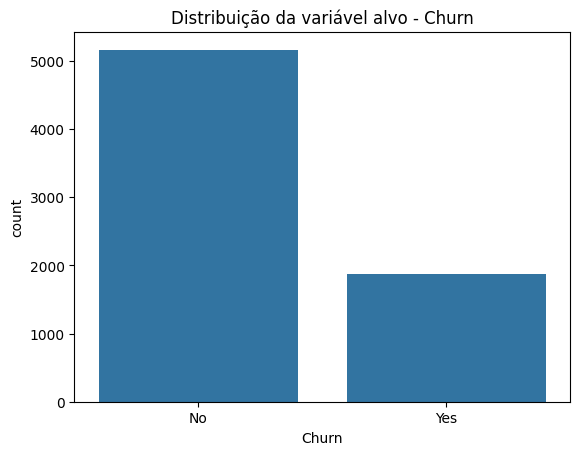

Churn
No     0.734215
Yes    0.265785
Name: proportion, dtype: float64

In [88]:
sns.countplot(data=df, x='Churn')
plt.title("Distribuição da variável alvo - Churn")
plt.show()

df['Churn'].value_counts(normalize=True)

As we see, the values of churn are not ballanced. So we will have to be carefull when we split the dataset for training and testing!!

### Transforming binary columns into numéric

Here, the ideia is to get all binary columns, that have values like "No or Yes" and "Male and Female" and transform this categories as 1 or 0.

In [89]:
bin_cols = ["gender","Partner","Dependents","PhoneService","PaperlessBilling","Churn"]
for col in bin_cols:
    df[col]=df[col].map({"Yes":1, "No":0, "Male":1, "Female":0})

## Graphical Analysis

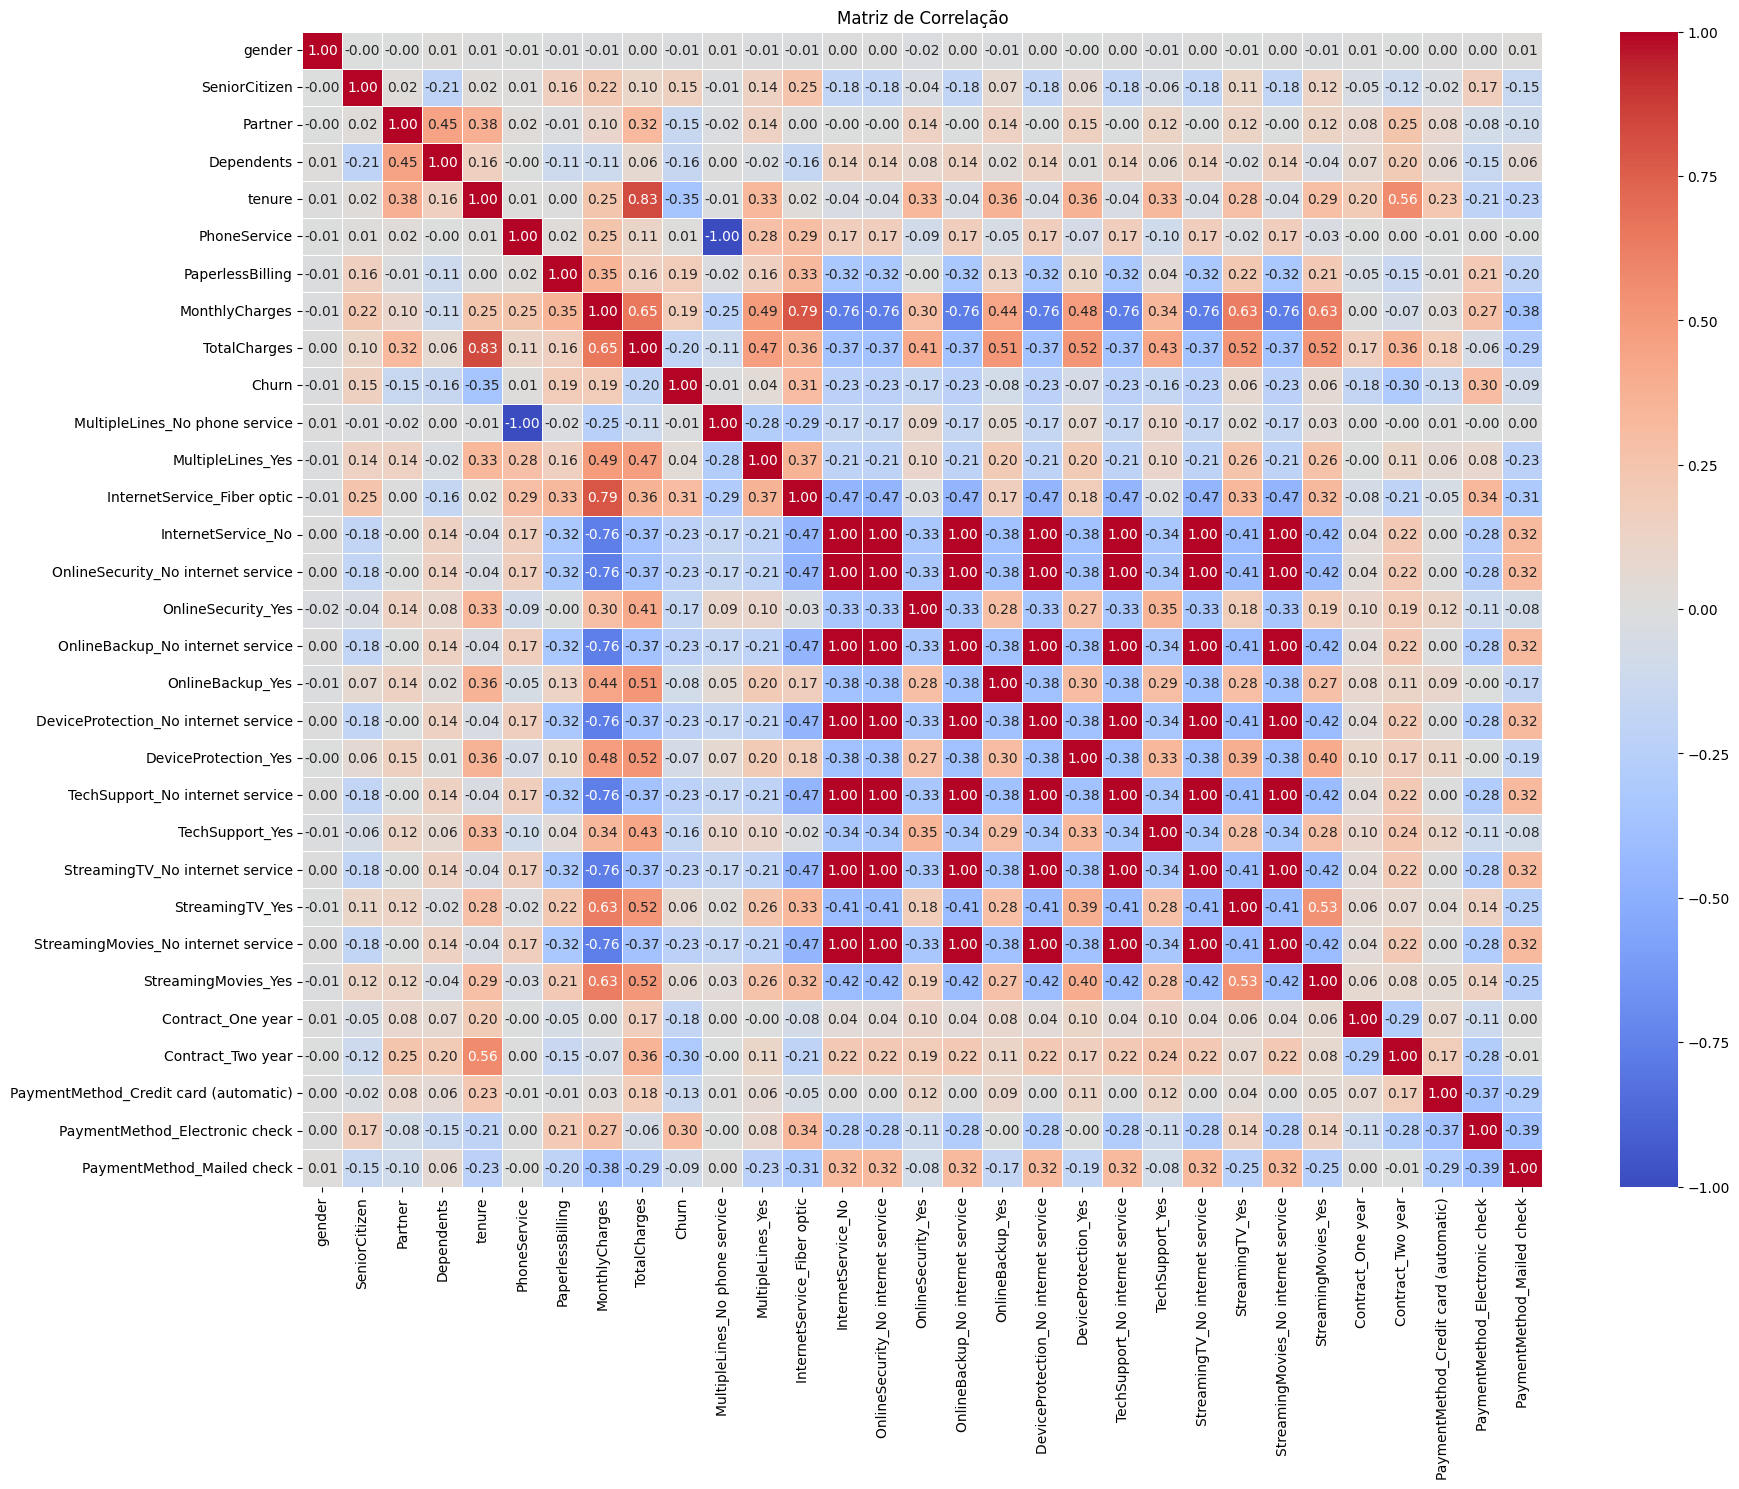

In [90]:
multi_cols= ["MultipleLines","InternetService","OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies","Contract","PaymentMethod"]

df_encoded = pd.get_dummies(df, columns=multi_cols, drop_first=True)

correlation_matrix = df_encoded.corr(method='pearson')

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Matriz de Correlação")
plt.show()

## Analyzing the pairplot for each numerical variable:

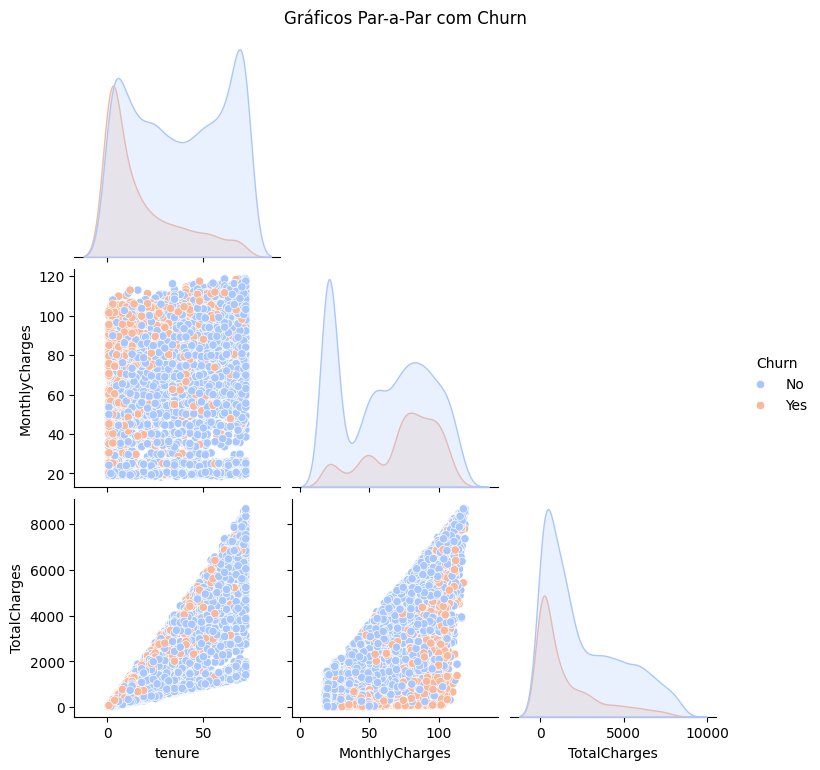

In [91]:
pairplot_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']
df_plot = df[pairplot_cols].copy()
df_plot['Churn'] = df_plot['Churn'].map({0: 'No', 1: 'Yes'})  # Para plotagem colorida

sns.pairplot(df_plot, hue='Churn', corner=True, diag_kind='kde', palette='coolwarm')
plt.suptitle("Gráficos Par-a-Par com Churn", y=1.02)
plt.show()

One interesting insight derived from the pairplot analysis is the clear relationship between customer tenure and churn behavior. The plots reveal that the longer a customer stays with the service, the lower the likelihood of churn.

More specifically, customers with shorter tenure periods (typically under 10 months) show a higher concentration of churn cases, while those who have been with the service longer are much more likely to remain. This suggests that early-stage customer retention strategies could have a significant impact on reducing overall churn rates.

This insight not only reinforces the value of long-term engagement but also highlights the importance of targeting new customers with onboarding and loyalty initiatives to improve long-term retention.

## Model Training

In [100]:
from sklearn.model_selection import train_test_split

# Split the data into features and target variable
X = df_encoded.drop(columns=['Churn'])
y = df_encoded['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [101]:
print(f"Distribuição de valores churn para treinamento: {y_train.to_frame().value_counts()}")

print(f"Distribuição de valores churn para teste: {y_test.to_frame().value_counts()}")

Distribuição de valores churn para treinamento: Churn
0        4130
1        1495
Name: count, dtype: int64
Distribuição de valores churn para teste: Churn
0        1033
1         374
Name: count, dtype: int64


In [97]:
from sklearn.metrics import classification_report, confusion_matrix

def model_analysis(model, X_test, y_test):
    """Function analyze a models performance with classification report metrics and confusion matrix."""
    
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    print("score: ", model.score(X_test, y_test))

    print("Confusion Matrix:")

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('🔍 Confusion Matrix')
    plt.tight_layout()
    plt.show()

In [104]:
from sklearn.metrics import precision_recall_curve
import numpy as np

def plot_precision_recall_vs_threshold(model, X_test, y_test):
    """Plot precision and recall against different thresholds for a given model.

    Args:
        model: trained model to evaluate
        X_test: features for testing the model
        y_test: true labels for testing the model
    """
    y_score = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision[:-1], label="Precision", color="blue")
    plt.plot(thresholds, recall[:-1], label="Recall", color="red")
    plt.xlabel('threshold')
    plt.ylabel('Score')
    plt.title('Precision-Recall vs Threshold')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

### Random Forest:

Model training and evaluation completed successfully.
Start Model Analysis
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1033
           1       0.64      0.46      0.54       374

    accuracy                           0.79      1407
   macro avg       0.73      0.68      0.70      1407
weighted avg       0.77      0.79      0.78      1407

score:  0.7882018479033405
Confusion Matrix:


/tmp/ipykernel_648834/567322945.py:22: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sylvio_neto/churn_model_fastapi/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


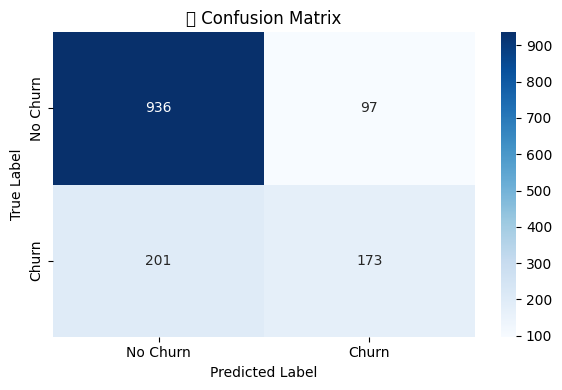

Precision and Recall vs Threshold


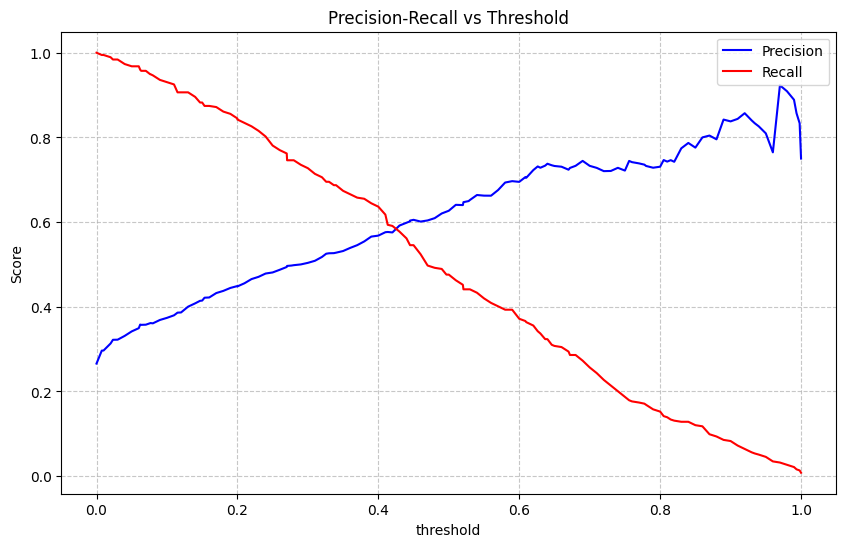

In [105]:
from sklearn.ensemble import RandomForestClassifier

# Split the data into features and target variable
X = df_encoded.drop(columns=['Churn'])
y = df_encoded['Churn']

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

print("Model training and evaluation completed successfully.")

print("Start Model Analysis")
model_analysis(rf_model, X_test, y_test)

print("Precision and Recall vs Threshold")
plot_precision_recall_vs_threshold(rf_model, X_test, y_test)

### XGBoost Training:

/home/sylvio_neto/churn_model_fastapi/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:39:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model training and evaluation completed successfully.
Start Model Analysis
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1033
           1       0.59      0.50      0.54       374

    accuracy                           0.77      1407
   macro avg       0.71      0.69      0.69      1407
weighted avg       0.76      0.77      0.77      1407

score:  0.7739872068230277
Confusion Matrix:


/tmp/ipykernel_648834/567322945.py:22: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sylvio_neto/churn_model_fastapi/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


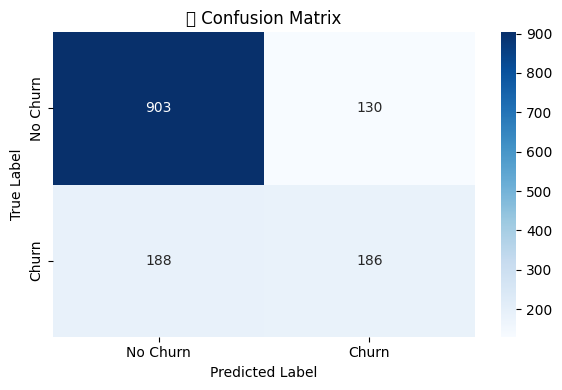

Precision and Recall vs Threshold


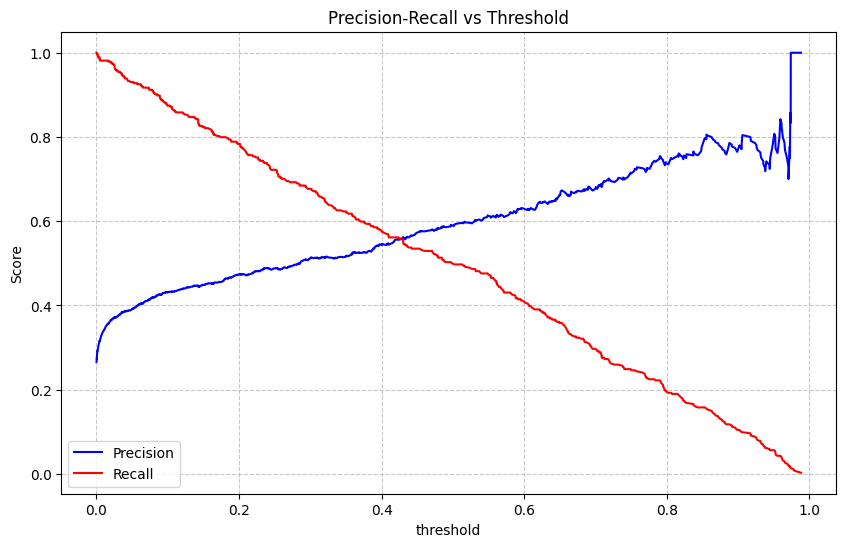

In [108]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

print("Model training and evaluation completed successfully.")

print("Start Model Analysis")
model_analysis(xgb_model, X_test, y_test)

print("Precision and Recall vs Threshold")
plot_precision_recall_vs_threshold(xgb_model, X_test, y_test)

### LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265778 -> initscore=-1.016151
[LightGBM] [Info] Start training from score -1.016151
Model training and evaluation completed successfully.
Start Model Analysis
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1033
           1       0.59      0.50      0.54       374

    accuracy                           0.77      1407
   macro avg       0.71      0.69      0.69      1

/tmp/ipykernel_648834/567322945.py:22: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sylvio_neto/churn_model_fastapi/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


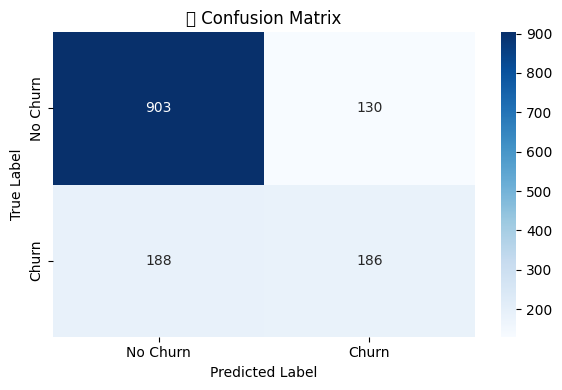

Precision and Recall vs Threshold


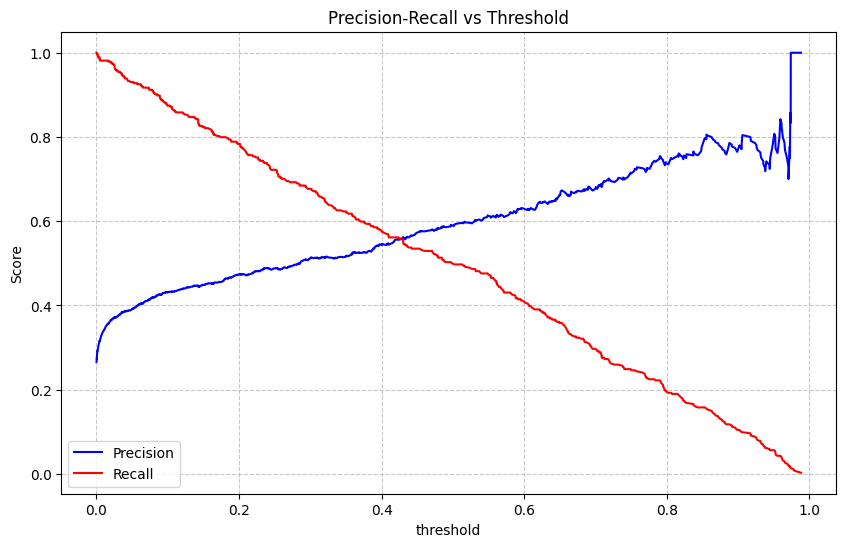

In [109]:
from lightgbm import LGBMClassifier

lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train, y_train)

print("Model training and evaluation completed successfully.")

print("Start Model Analysis")
model_analysis(xgb_model, X_test, y_test)

print("Precision and Recall vs Threshold")
plot_precision_recall_vs_threshold(xgb_model, X_test, y_test)